# DAY14

## 经典机器学习中的SHAP可解释分析

In [2]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [3]:

from sklearn.ensemble import RandomForestClassifier #随机森林分类器

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的随机森林 ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数随机森林 (训练集 -> 测试集) ---")
import time # 这里介绍一个新的库，time库，主要用于时间相关的操作，因为调参需要很长时间，记录下会帮助后人知道大概的时长
start_time = time.time() # 记录开始时间
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(X_test) # 在测试集上预测
end_time = time.time() # 记录结束时间

print(f"训练与预测耗时: {end_time - start_time:.4f} 秒")
print("\n默认随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数随机森林 (训练集 -> 测试集) ---
训练与预测耗时: 0.9542 秒

默认随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1059
           1       0.79      0.30      0.43       441

    accuracy                           0.77      1500
   macro avg       0.78      0.63      0.64      1500
weighted avg       0.77      0.77      0.73      1500

默认随机森林 在测试集上的混淆矩阵：
[[1023   36]
 [ 309  132]]


## SHAP 原理简介

**目标：** 理解复杂机器学习模型（尤其是“黑箱”模型，如随机森林、梯度提升树、神经网络等）**为什么**会对**特定输入**做出**特定预测**。 SHAP 提供了一种统一的方法来解释模型的输出。

**核心思想：合作博弈论中的 Shapley 值**

SHAP (SHapley Additive exPlanations) 的核心基于博弈论中的 **Shapley 值**概念。想象一个合作游戏：

1.  **玩家 (Players):** 模型的**特征 (Features)** 就是玩家。
2.  **游戏 (Game):** 目标是预测某个样本的输出值。
3.  **合作 (Coalition):** 不同的特征子集可以“合作”起来进行预测。
4.  **奖励/价值 (Payout/Value):** 某个特征子集进行预测得到的值。
5.  **目标：** 如何**公平地**将最终预测结果（相对于平均预测结果的“收益”）分配给每个参与的特征（玩家）？

**Shapley 值的计算思路（概念上）：**

为了计算一个特定特征（比如“特征 A”）对某个预测的贡献（它的 Shapley 值），SHAP 会考虑：

1.  **所有可能的特征组合（子集/联盟）：** 从没有特征开始，到包含所有特征。
2.  **特征 A 的边际贡献：** 对于**每一个**特征组合，比较“包含特征 A 的组合的预测值”与“不包含特征 A 但包含其他相同特征的组合的预测值”之间的**差异**。这个差异就是特征 A 在这个特定组合下的“边际贡献”。
3.  **加权平均：** Shapley 值是该特征在**所有可能**的特征组合中边际贡献的**加权平均值**。权重确保了分配的公平性。

**SHAP 的关键特性 (加性解释 - Additive Explanations):**

SHAP 的一个重要特性是**加性 (Additive)**。这意味着：

*   **基准值 (Base Value / Expected Value):** 这是模型在整个训练（或背景）数据集上的平均预测输出。可以理解为没有任何特征信息时的“默认”预测。
*   **SHAP 值之和：** 对于**任何一个**样本的预测，**所有特征的 SHAP 值加起来，再加上基准值，就精确地等于该样本的模型预测值**。
    ```
    模型预测值(样本 X) = 基准值 + SHAP值(特征1) + SHAP值(特征2) + ... + SHAP值(特征N)
    ```

**为什么会生成 `shap_values` 数组？**

根据上述原理，SHAP 需要为**每个样本的每个特征**计算一个贡献值（SHAP 值）：

1.  **解释单个预测：** SHAP 的核心是解释**单个**预测结果。
2.  **特征贡献：** 对于这个预测，我们需要知道**每个特征**是把它往“高”推了，还是往“低”推了（相对于基准值），以及推了多少。
3.  **数值化：** 这个“推力”的大小和方向就是该特征对该样本预测的 **SHAP 值**。

因此：

*   **对于回归问题：**
    *   模型只有一个输出。
    *   对 `n_samples` 个样本中的**每一个**，计算 `n_features` 个特征各自的 SHAP 值。
    *   这就自然形成了形状为 `(n_samples, n_features)` 的数组。 `shap_values[i, j]` 代表第 `i` 个样本的第 `j` 个特征对该样本预测值的贡献。

*   **对于分类问题：**
    *   模型通常为**每个类别**输出一个分数或概率。
    *   SHAP 需要解释模型是如何得到**每个类别**的分数的。
    *   因此，对 `n_samples` 个样本中的**每一个**，**分别为每个类别**计算 `n_features` 个特征的 SHAP 值。
    *   最常见的组织方式是返回一个**列表**，列表长度等于类别数。列表的第 `k` 个元素是一个 `(n_samples, n_features)` 的数组，表示所有样本的所有特征对预测**类别 `k`** 的贡献。
    *   `shap_values[k][i, j]` 代表第 `i` 个样本的第 `j` 个特征对该样本预测**类别 `k`** 的贡献。

**总结:**

SHAP 通过计算每个特征对单个预测（相对于平均预测）的边际贡献（Shapley 值），提供了一种将模型预测分解到每个特征上的方法。这种分解对于每个样本和每个特征（以及分类问题中的每个类别）都需要进行，因此生成了我们看到的 `shap_values` 数组结构。


In [ ]:
import shap
import matplotlib.pyplot as plt

# 初始化 SHAP 解释器
explainer = shap.TreeExplainer(rf_model)

# 计算 SHAP 值（基于测试集），这个shap_values是一个numpy数组，表示每个特征对每个样本的贡献值
# 这里大家先知道这是个numpy数组即可，我们后面学习完numpy在来回头解读这个值
shap_values = explainer.shap_values(X_test) # 这个计算耗时

## shap的维度要求

非常多的同学和我反映过代码跑不通，甚至换个电脑就不行了等玄学问题，本质都是由于没有搞清楚shap的维度要求，这里记录下，希望对大家有所帮助。

分类问题和回归问题输出的shap_values的形状不同。

- 分类问题：shap_values.shape =(n_samples, n_features, n_classes)
- 回归问题：shap_values.shape = (n_samples, n_features)

**数据维度的要求将是未来学习神经网络最重要的东西之一。**

In [ ]:
shap_values # 每一行代表一个样本，每一列代表一个特征，值表示该特征对该样本的预测结果的影响程度。正值表示该特征对预测结果有正向影响，负值表示负向影响。

array([[[ 9.07465700e-03, -9.07465700e-03],
        [ 7.21456498e-03, -7.21456498e-03],
        [ 4.55189444e-02, -4.55189444e-02],
        ...,
        [ 7.12857198e-05, -7.12857198e-05],
        [ 4.67733508e-05, -4.67733508e-05],
        [ 1.61298135e-04, -1.61298135e-04]],

       [[-1.02606871e-02,  1.02606871e-02],
        [ 1.85572634e-02, -1.85572634e-02],
        [-1.64992848e-02,  1.64992848e-02],
        ...,
        [ 2.00070852e-04, -2.00070852e-04],
        [ 5.11798841e-05, -5.11798841e-05],
        [ 1.02827796e-04, -1.02827796e-04]],

       [[ 3.21529115e-03, -3.21529115e-03],
        [ 1.28184070e-02, -1.28184070e-02],
        [ 1.02124914e-01, -1.02124914e-01],
        ...,
        [ 1.73012306e-04, -1.73012306e-04],
        [ 4.74133256e-05, -4.74133256e-05],
        [ 1.26753231e-04, -1.26753231e-04]],

       ...,

       [[ 1.15222741e-03, -1.15222741e-03],
        [-1.71843266e-02,  1.71843266e-02],
        [-3.04994337e-02,  3.04994337e-02],
        ...,
     

In [6]:
shap_values.shape # 第一维是样本数，第二维是特征数，第三维是类别数

(1500, 31, 2)

In [7]:
print("shap_values shape:", shap_values.shape)
print("shap_values[0] shape:", shap_values[0].shape)
print("shap_values[:, :, 0] shape:", shap_values[:, :, 0].shape)
print("X_test shape:", X_test.shape)

shap_values shape: (1500, 31, 2)
shap_values[0] shape: (31, 2)
shap_values[:, :, 0] shape: (1500, 31)
X_test shape: (1500, 31)


上面这个输出有点玄学，不同电脑可能输出不同，中间的2个谁和x_test的尺寸一样就选谁

--- 1. SHAP 特征重要性条形图 ---


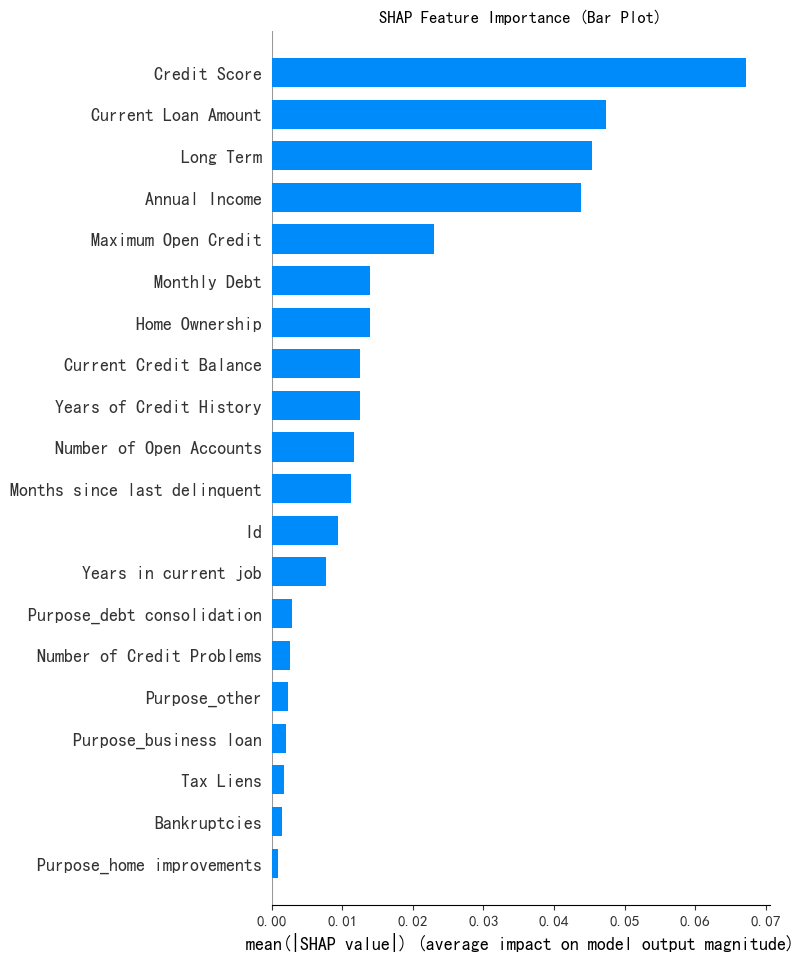

In [8]:
# --- 1. SHAP 特征重要性条形图 (Summary Plot - Bar) ---
print("--- 1. SHAP 特征重要性条形图 ---")
shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar",show=False)  #  这里的show=False表示不直接显示图形,这样可以继续用plt来修改元素，不然就直接输出了
plt.title("SHAP Feature Importance (Bar Plot)")
plt.show()

--- 2. SHAP 特征重要性蜂巢图 ---


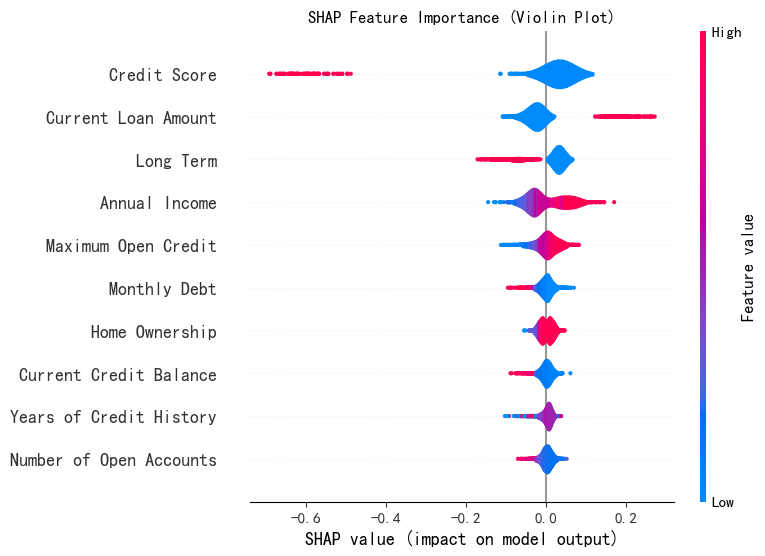

In [9]:
# --- 2. SHAP 特征重要性蜂巢图 (Summary Plot - Violin) ---
print("--- 2. SHAP 特征重要性蜂巢图 ---")
shap.summary_plot(shap_values[:, :, 0], X_test,plot_type="violin",show=False,max_display=10) # 这里的show=False表示不直接显示图形,这样可以继续用plt来修改元素，不然就直接输出了
plt.title("SHAP Feature Importance (Violin Plot)")
plt.show()
# 注意下上面几个参数，plot_type可以是bar和violin，max_display表示显示前多少个特征，默认是20个